In [1]:
import pandas as pd

df = pd.read_csv("https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv", parse_dates=["ds"])
df.head()

,unique_id,ds,y
0,AirPassengers,1949-01-01,112
1,AirPassengers,1949-02-01,118
2,AirPassengers,1949-03-01,132
3,AirPassengers,1949-04-01,129
4,AirPassengers,1949-05-01,121


In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [3]:
sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq="MS", n_jobs=-1)

sf.fit(df)
sf.predict(h=12, level=[95])

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,AirPassengers,1961-01-01,444.309570,421.279327,467.339813
1,AirPassengers,1961-02-01,418.213745,390.227631,446.199829
2,AirPassengers,1961-03-01,446.243408,412.910034,479.576782
3,AirPassengers,1961-04-01,488.234222,450.621368,525.847107
4,AirPassengers,1961-05-01,499.237061,457.694824,540.779297
5,AirPassengers,1961-06-01,562.236206,517.130981,607.341431
6,AirPassengers,1961-07-01,649.236450,600.822449,697.650513
7,AirPassengers,1961-08-01,633.236389,581.727783,684.744934
8,AirPassengers,1961-09-01,535.236389,480.808289,589.664490
9,AirPassengers,1961-10-01,488.236389,431.037781,545.434998


In [4]:
Y_df = pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


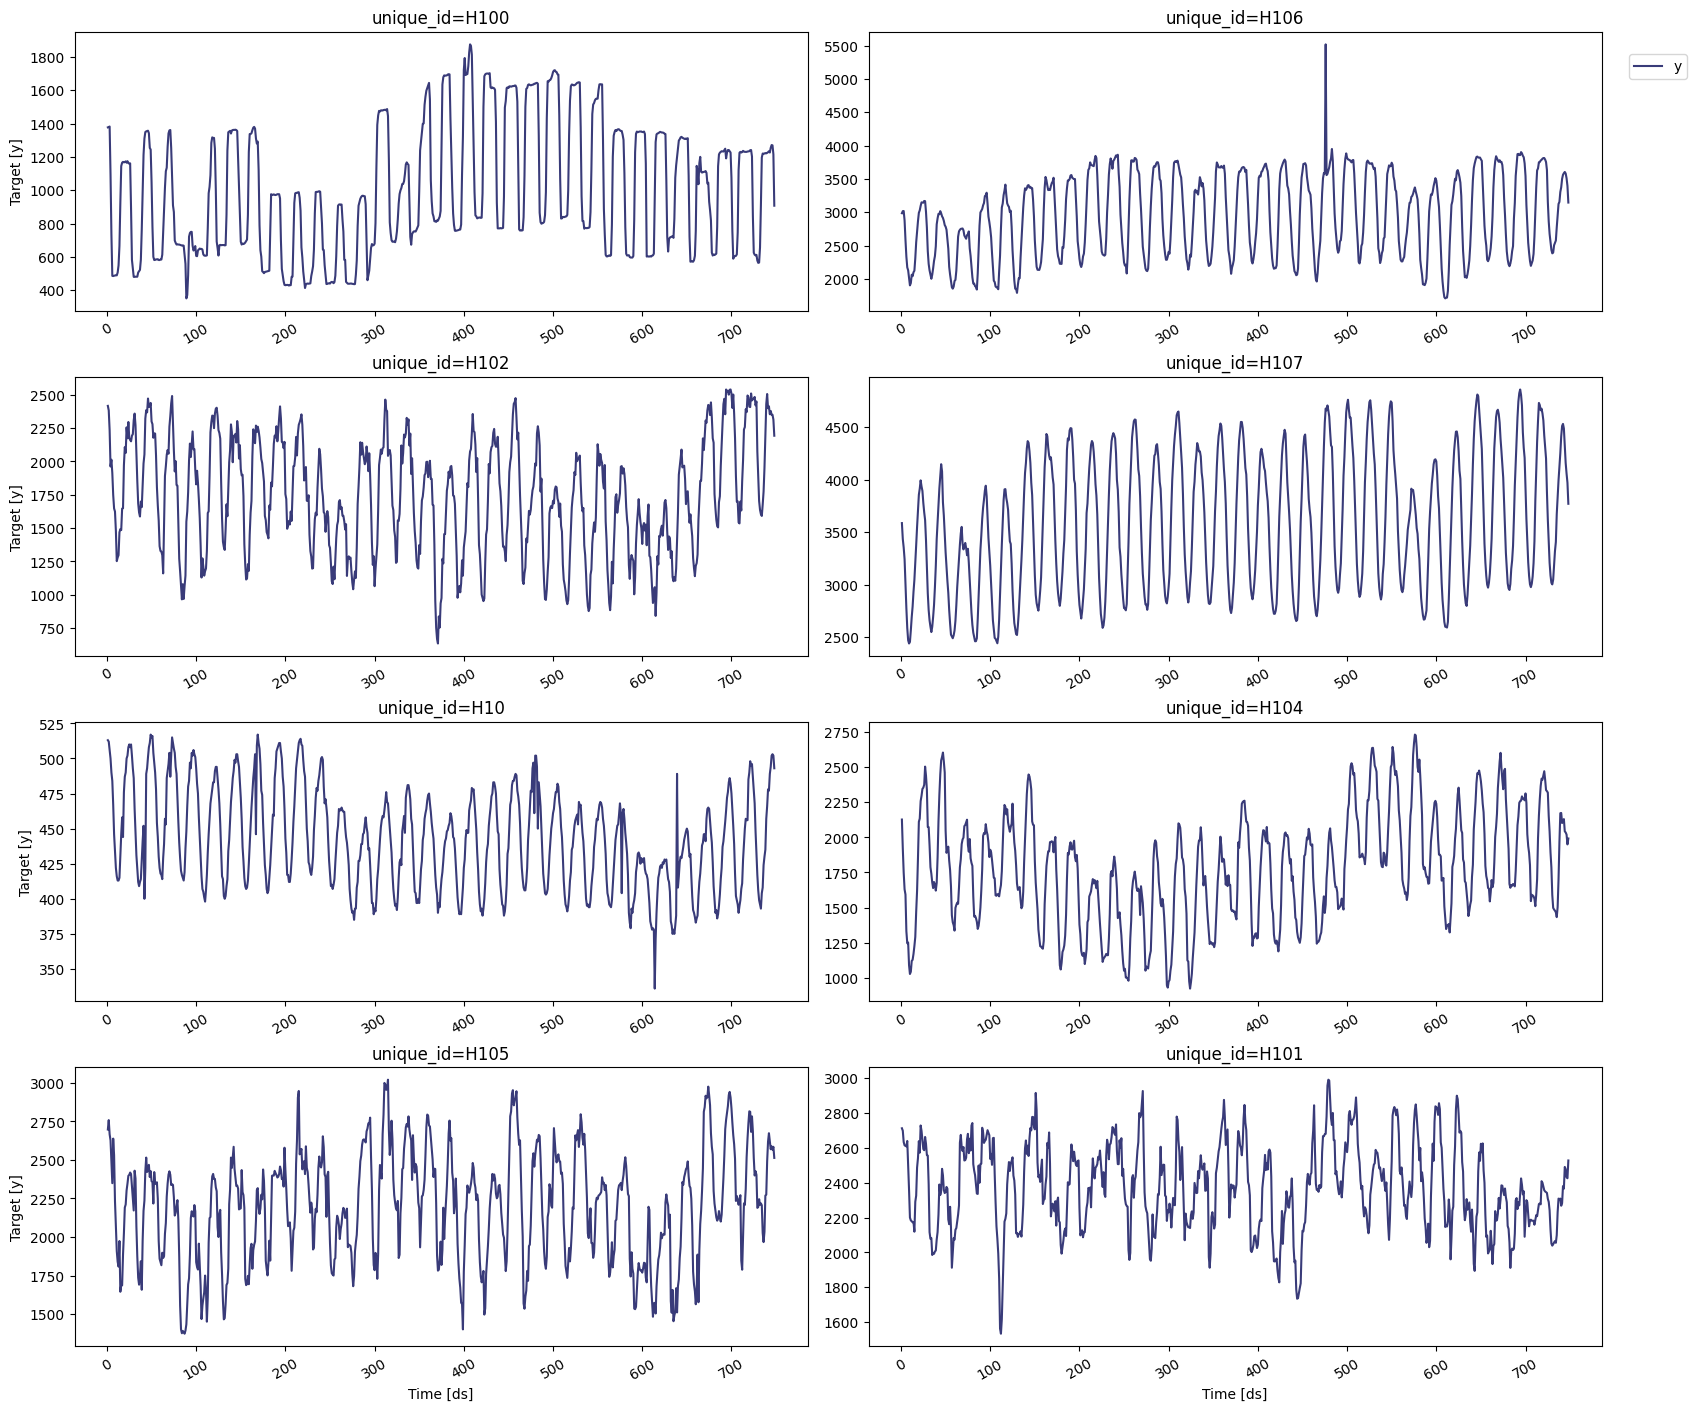

In [5]:
uids = Y_df["unique_id"].unique()[:10]  # Select 10 ids to make the example faster
Y_df = Y_df.query("unique_id in @uids")
StatsForecast.plot(Y_df)

In [6]:
from statsforecast.models import CrostonClassic as Croston
from statsforecast.models import DynamicOptimizedTheta as DOT
from statsforecast.models import (
    HistoricAverage,
    HoltWinters,
    SeasonalNaive,
)

# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
]

# Instantiate StatsForecast class as sf
sf = StatsForecast(
    models=models,
    freq=1,
    fallback_model=SeasonalNaive(season_length=7),
    n_jobs=-1,
)

In [7]:
%%time
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])
forecasts_df.head()

CPU times: user 9.71 ms, sys: 147 ms, total: 157 ms
Wall time: 10.6 s


,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,H1,749,829.0,443.081639,1214.918361,829.0,443.081639,1214.918361,635.0,537.384079,732.615921,639.820856,382.001748,897.639964,597.484838,581.159000,618.076929
1,H1,750,807.0,421.081639,1192.918361,807.0,421.081639,1192.918361,572.0,474.384079,669.615921,639.820856,382.001748,897.639964,535.542445,513.422884,558.643151
2,H1,751,785.0,399.081639,1170.918361,785.0,399.081639,1170.918361,532.0,434.384079,629.615921,639.820856,382.001748,897.639964,492.819783,463.309630,517.979609
3,H1,752,756.0,370.081639,1141.918361,756.0,370.081639,1141.918361,493.0,395.384079,590.615921,639.820856,382.001748,897.639964,461.005823,433.075966,485.041771
4,H1,753,719.0,333.081639,1104.918361,719.0,333.081639,1104.918361,477.0,379.384079,574.615921,639.820856,382.001748,897.639964,440.918265,413.423987,468.724252


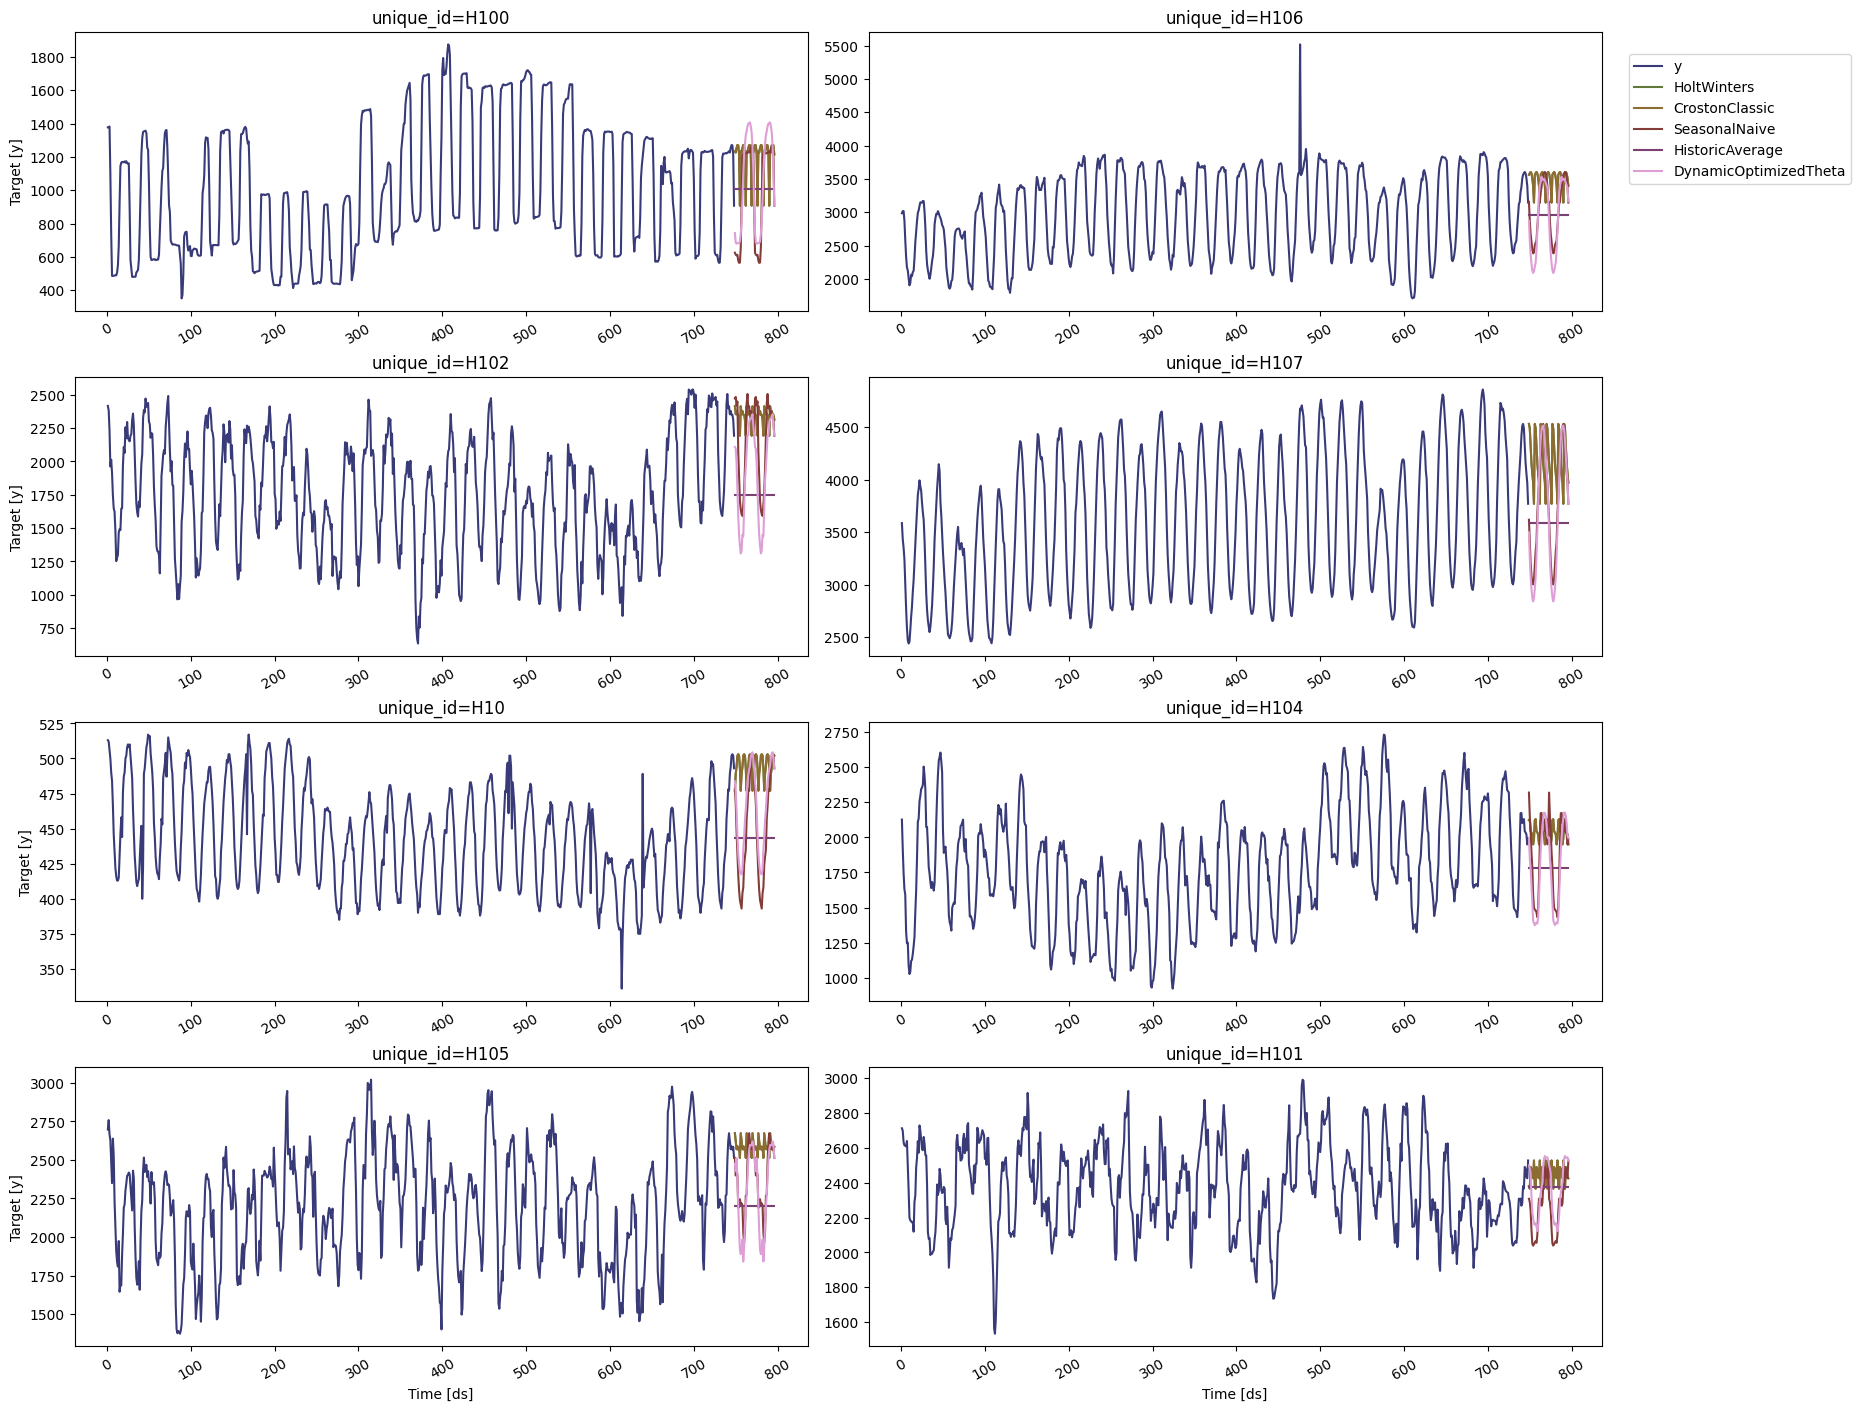

In [21]:
sf.plot(Y_df, forecasts_df)

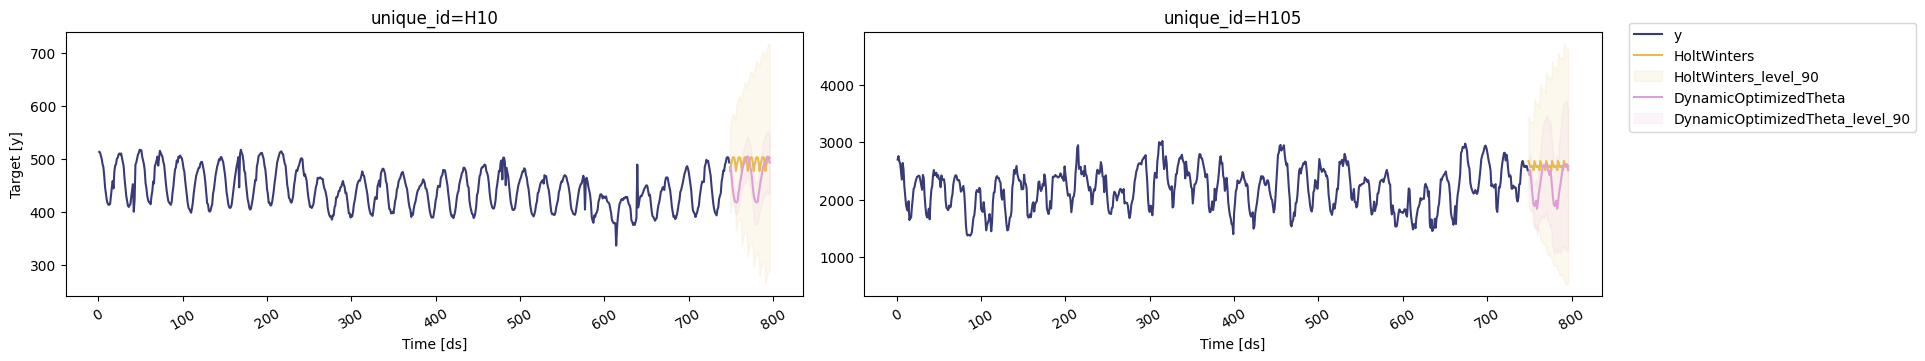

In [22]:
# Plot to unique_ids and some selected models
sf.plot(
    Y_df,
    forecasts_df,
    models=["HoltWinters", "DynamicOptimizedTheta"],
    unique_ids=["H10", "H105"],
    level=[90],
)

In [23]:
cv_df = sf.cross_validation(df=Y_df, h=24, step_size=24, n_windows=2)

In [24]:
cv_df.head()

,unique_id,ds,cutoff,y,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
0,H1,701,700,619.0,847.0,742.669064,691.0,638.488571,620.213464
1,H1,702,700,565.0,820.0,742.669064,618.0,638.488571,555.381384
2,H1,703,700,532.0,790.0,742.669064,563.0,638.488571,510.383799
3,H1,704,700,495.0,784.0,742.669064,529.0,638.488571,477.623940
4,H1,705,700,481.0,752.0,742.669064,504.0,638.488571,456.311806


In [26]:
from utilsforecast.losses import mse


def evaluate_cv(df, metric):
    models = df.columns.drop(["unique_id", "ds", "y", "cutoff"]).tolist()
    evals = metric(df, models=models)
    evals["best_model"] = evals[models].idxmin(axis=1)
    return evals

In [27]:
evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df.head()

,unique_id,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
0,H1,44888.020833,28038.758825,1422.666667,21317.848309,938.578473,DynamicOptimizedTheta
1,H10,2812.916667,1483.483683,96.895833,1387.035567,145.758321,SeasonalNaive
2,H100,121625.375000,91945.293654,12019.000000,78496.693670,48482.175667,SeasonalNaive
3,H101,28453.395833,16183.631871,10944.458333,30003.876007,36071.407444,SeasonalNaive
4,H102,232924.854167,132655.241387,12699.895833,289089.384267,28613.315599,SeasonalNaive


In [28]:
evaluation_df["best_model"].value_counts().to_frame().reset_index()

,best_model,count
0,SeasonalNaive,7
1,DynamicOptimizedTheta,3


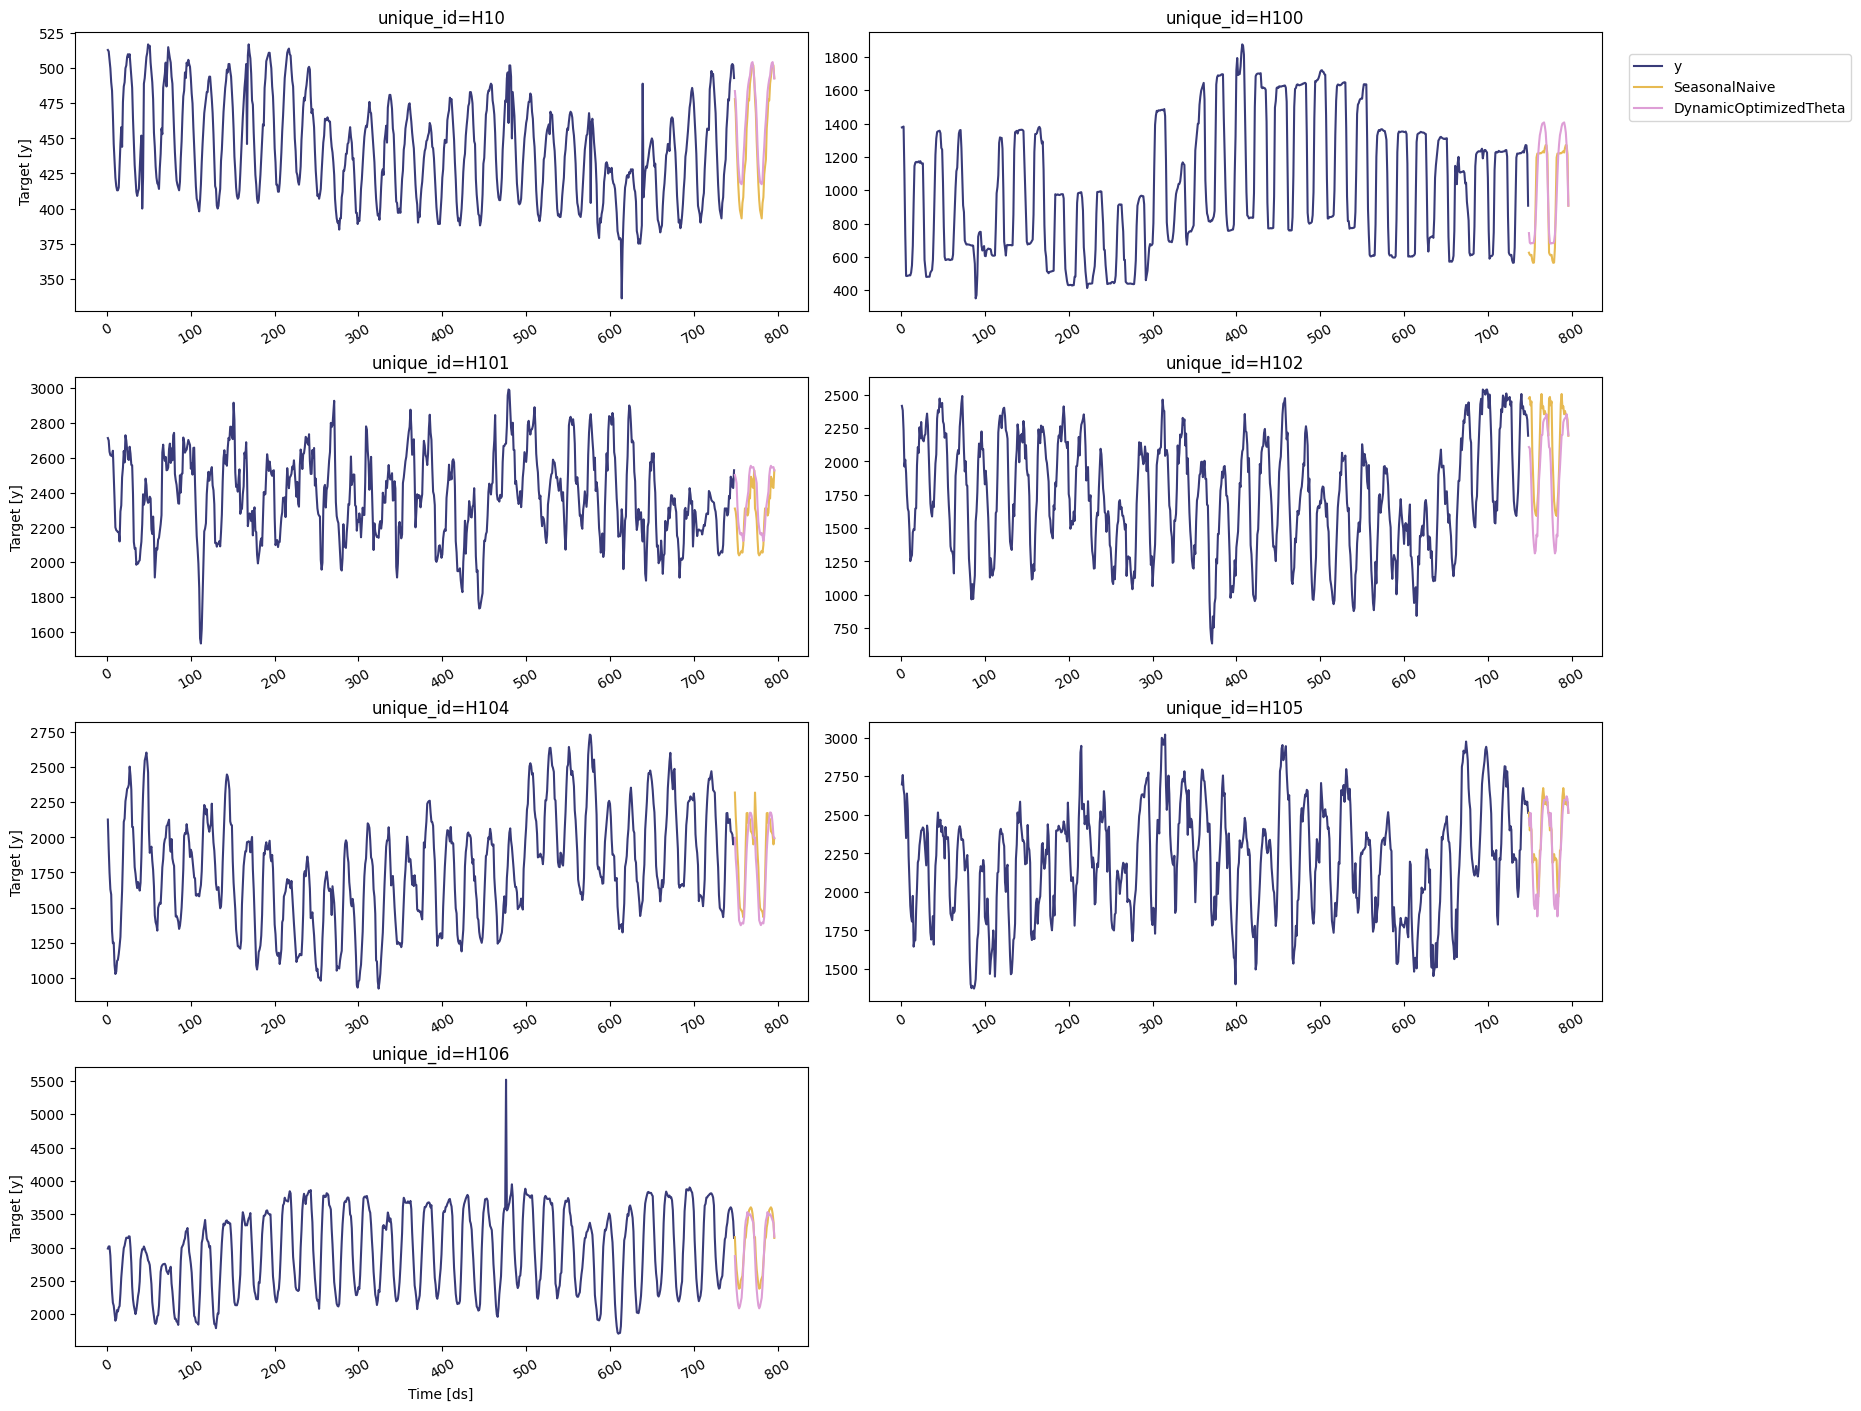

In [29]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"')["unique_id"]
sf.plot(
    Y_df, forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive", "DynamicOptimizedTheta"]
)

In [30]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    with_best = forecasts_df.merge(evaluation_df[["unique_id", "best_model"]])
    res = with_best[["unique_id", "ds"]].copy()
    for suffix in ("", "-lo-90", "-hi-90"):
        res[f"best_model{suffix}"] = with_best.apply(
            lambda row: row[row["best_model"] + suffix], axis=1
        )
    return res

In [31]:
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model,best_model-lo-90,best_model-hi-90
0,H1,749,597.484838,581.159000,618.076929
1,H1,750,535.542445,513.422884,558.643151
2,H1,751,492.819783,463.309630,517.979609
3,H1,752,461.005823,433.075966,485.041771
4,H1,753,440.918265,413.423987,468.724252


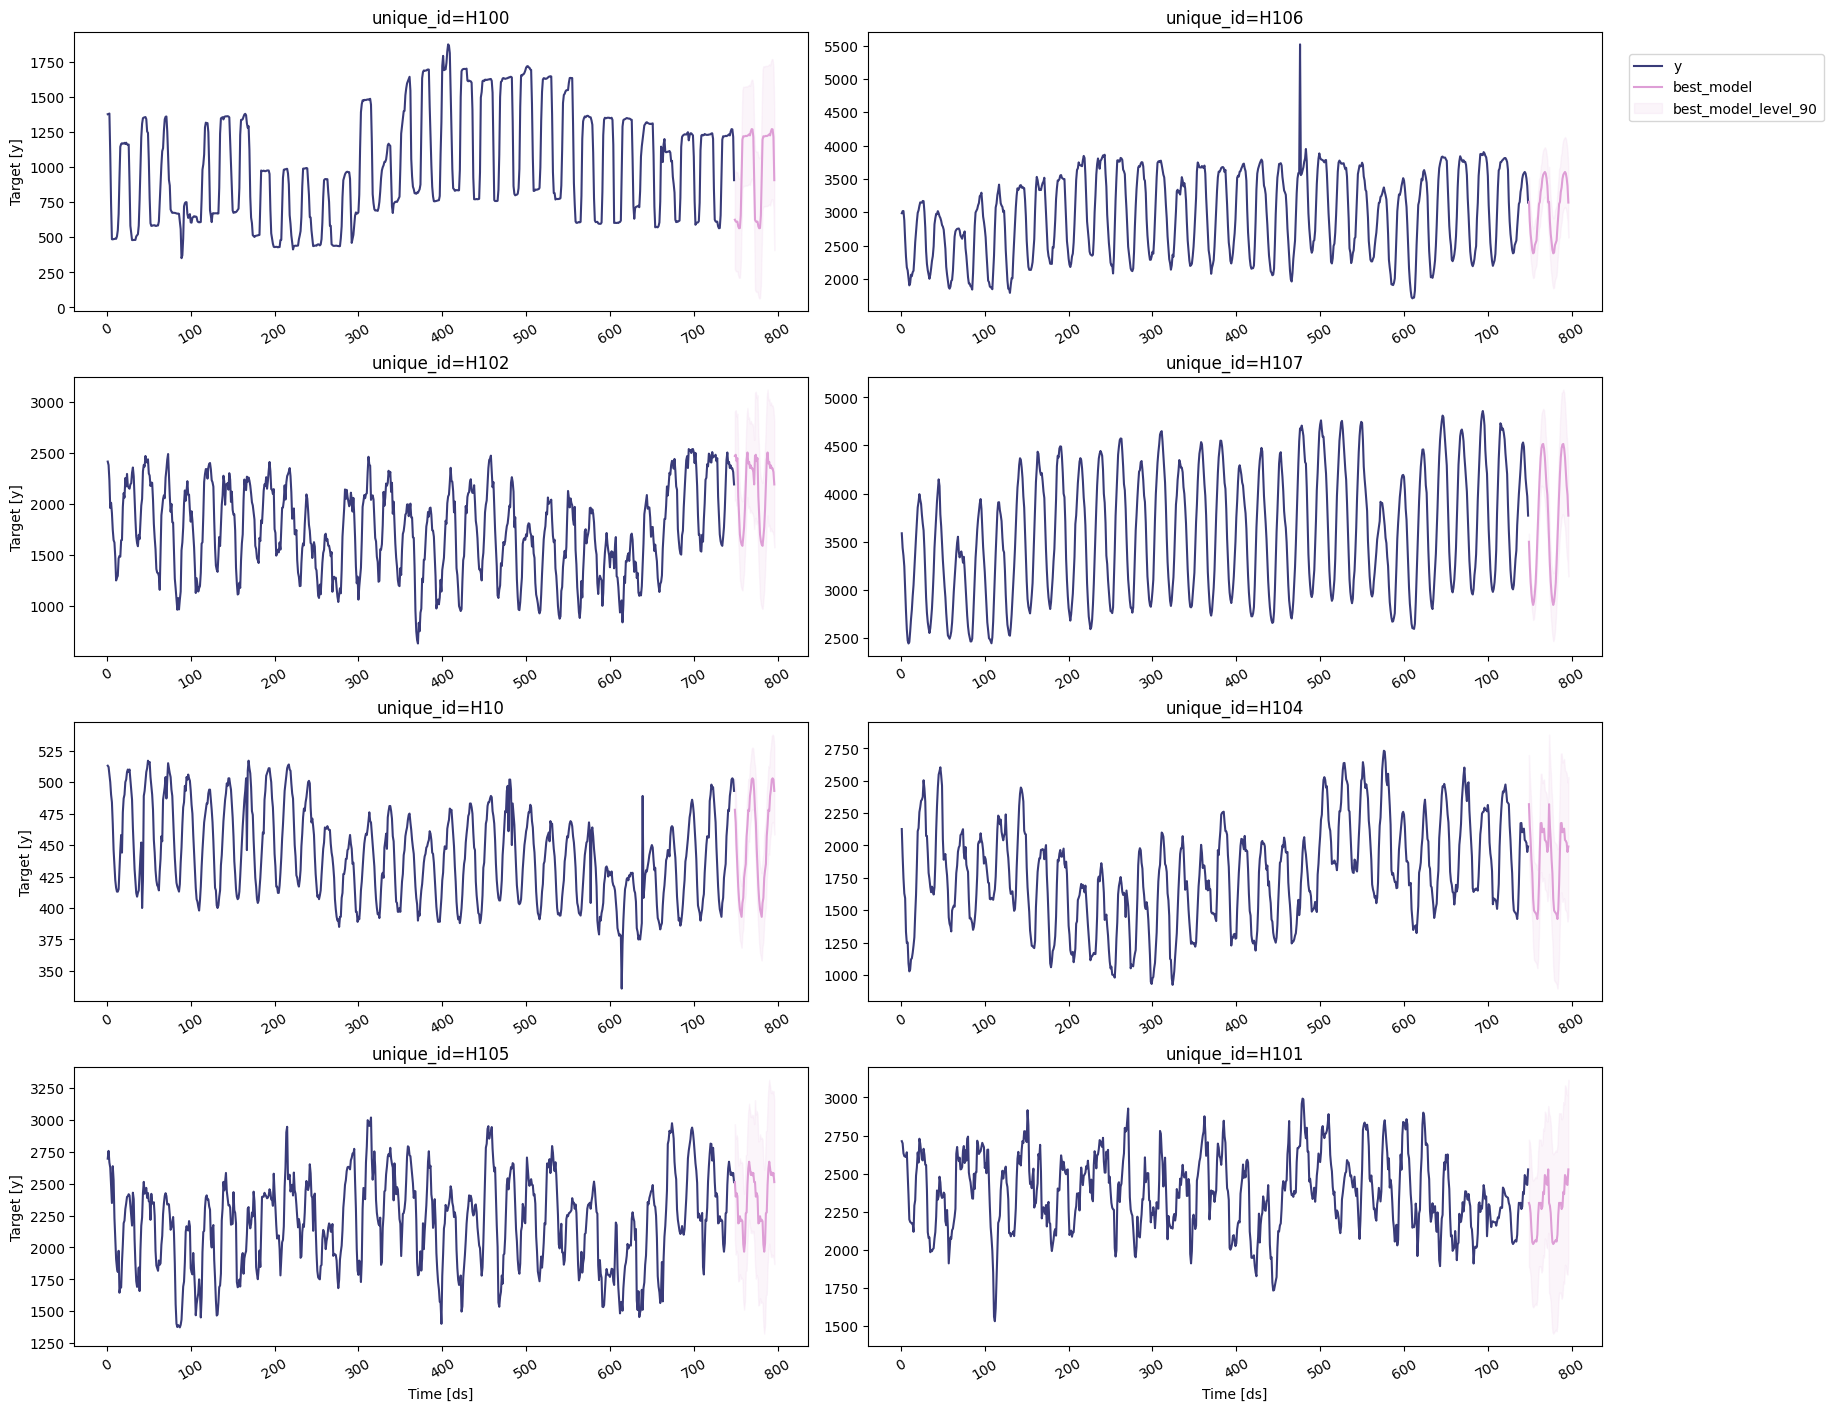

In [32]:
sf.plot(Y_df, prod_forecasts_df, level=[90])